# Algotrading - Aula 6

Simulando Indicadores Técnicos com biblioteca pandas-ta
___


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import random

# Para fazer o backtesting
from backtesting_v2 import evaluateHist, evaluateIntr, Strategy, Order

In [2]:
# instalando o pandas-ta

!pip install pandas-ta

import pandas_ta as ta
ticker = 'AAPL'

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=fd4b82f45afe65bdc80208f8632fcc78515ebb67bb3460200a3981f6aefb656e
  Stored in directory: /home/antonio/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


Primeiro vamos pegar alguma série de preços

In [3]:
import yahoofinancials as yf

start_date = '2018-03-06'
end_date =  '2020-03-06'

data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')

# Ler os dados do JSON
raw = pd.DataFrame(data[ticker]['prices']).dropna()
# Converter a data para o tipo correto datetime
raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
# Indica a data como o índice de cada linha
raw = raw.set_index('formatted_date')
# Removendo as colunas que não interessam
df = raw.iloc[:,1:]

# Acertando a ordem das colunas
df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
# Salvando o CSV
df.to_csv('{}.csv'.format(ticker))

In [4]:
df = pd.read_csv('{}.csv'.format(ticker))
df.head()

,formatted_date,open,high,low,close,adjclose,volume
0,2018-03-06,44.477501,44.562500,44.032501,44.167500,42.105804,95154000
1,2018-03-07,43.735001,43.962502,43.567501,43.757500,41.714947,126814000
2,2018-03-08,43.869999,44.279999,43.767502,44.235001,42.170155,95096400
3,2018-03-09,44.490002,45.000000,44.347500,44.994999,42.894691,128740800
4,2018-03-12,45.072498,45.597500,45.052502,45.430000,43.309372,128828400


___

A biblioteca pandas-ta se acopla ao DataFrame e permite fazer o cálculo de indicadores técnicos diretamente, desde que haja pelo menos uma coluna chamada **close**. Note que alguns indicadores podem necessitar guardar também open, high, low e volume.

Para maiores informações: https://twopirllc.github.io/pandas-ta

Ou então acionar a função help():

In [5]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)
    
    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.
    
    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/
    
    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal
    
        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
          

Note que a função tem alguns argumentos de entrada parametrizáveis como: fast, slow and signal
Ainda, a saída é dada um por DataFrame. Portanto precisamos ajustar o notebook da aula para casar as entradas e saídas
___

### Moving Average Convergence Divergence MACD

Calcula-se duas médias móveis de forma exponencial, sendo uma rápida e uma lenta. 

Em seguida subtrai-se a lenta da rápida e calcula-se uma nova média móvel exponencial dessa nova série, chamada de signal

Se MACD estiver acima do signal compra, senão vende.

In [6]:
class MACD(Strategy):

    def __init__(self):
        
        # Quantidade de dias de cada média móvel
        self.slow = 26
        self.fast = 12
        self.signal = 9
        
        # Lista para guardar os preços e o indicador
        self.prices = []
        self.indicator = []
    
        # Side da estratégia (+1 Compra/-1 Vende)
        self.side = 0
        
        #self.init_capital = 100
        #self.avail_capital = self.init_capital


    def receive(self, event):

        price = event.price[3] # Captura o preço atual vindo do evento
        
        # Montando a série de preços:
        self.prices.append(price)
        
        # Se a quantidade de preços observados for superior a janela mais lenta + janela de signal
        if len(self.prices) >= self.slow + self.signal:
            
            # Monta a lista de preços em um dataframe
            close = pd.DataFrame({'close': self.prices})
            
            # Calcula o MACD usando a biblioteca TA
            macd = close.ta.macd(fast=self.fast, slow=self.slow, signal=self.signal)
            
            # Guarda o indicador para o gráfico
            self.indicator.append([macd.iloc[-1, 0], macd.iloc[-1, 2]])
                        
            # O sinal vai ser um valor 1 ou -1
            signal = (macd.iloc[-1, 0] > macd.iloc[-1, 2])*2 - 1
            
            # Ajustando a posição
            if self.side != signal:
                if self.side == 1:
                    self.submit(self.id, Order(event.instrument, Order.S, self.side, 0))
                elif self.side == -1:
                    self.submit(self.id, Order(event.instrument, Order.B, -self.side, 0))
                
                if signal == 1:
                    self.submit(self.id, Order(event.instrument, Order.B, signal, 0))
                else:
                    self.submit(self.id, Order(event.instrument, Order.SS, -signal, 0))
                    
                self.side = signal
                
    #def fill(self, id, instrument, price, quantity, status):
    #    print(f"{id} - {instrument} {quantity}@{price}")

modelMACD = MACD()
print(evaluateHist(modelMACD, {'AAPL': 'AAPL.csv'}))

Gross Profit: $59.73
Gross Loss: $-36.32
Gross Total: $23.41

Number of trades: 35
Hitting Ratio: 45.71%
Number of profit trades: 16
Number of loss trades: 19
Average number of events per trade: 13.40

Max win trade: $9.40
Avg win trade: $3.73
Max loss trade: $-4.08
Avg loss trade: $-1.91
Avg all trades: $0.67
Win/Loss ratio: 1.95

Max Profit: $12.22
Max Profit High/Low: $13.75
Max Drawdown: $-4.08
Max Drawdown High/Low: $-5.84

Max Allocation: $77.84
Avg Allocation: $48.95
Max Cash Required (margin): $77.84

Gross Total: $23.41
Total Fees: $7.00
Total Taxes: $10.64
Net Total: $5.77

Gross Return: 37.34%
Average Return: 1.07%
Net Return: 2.25%
Net Return Avg Alocation: 11.78%

Number of days: 504
Initial Capital: $10000.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $2924.05
Net Total + Carry: $2929.81
Net Return Capital: 29.30%
Net Return Capital Yearly: 13.71%




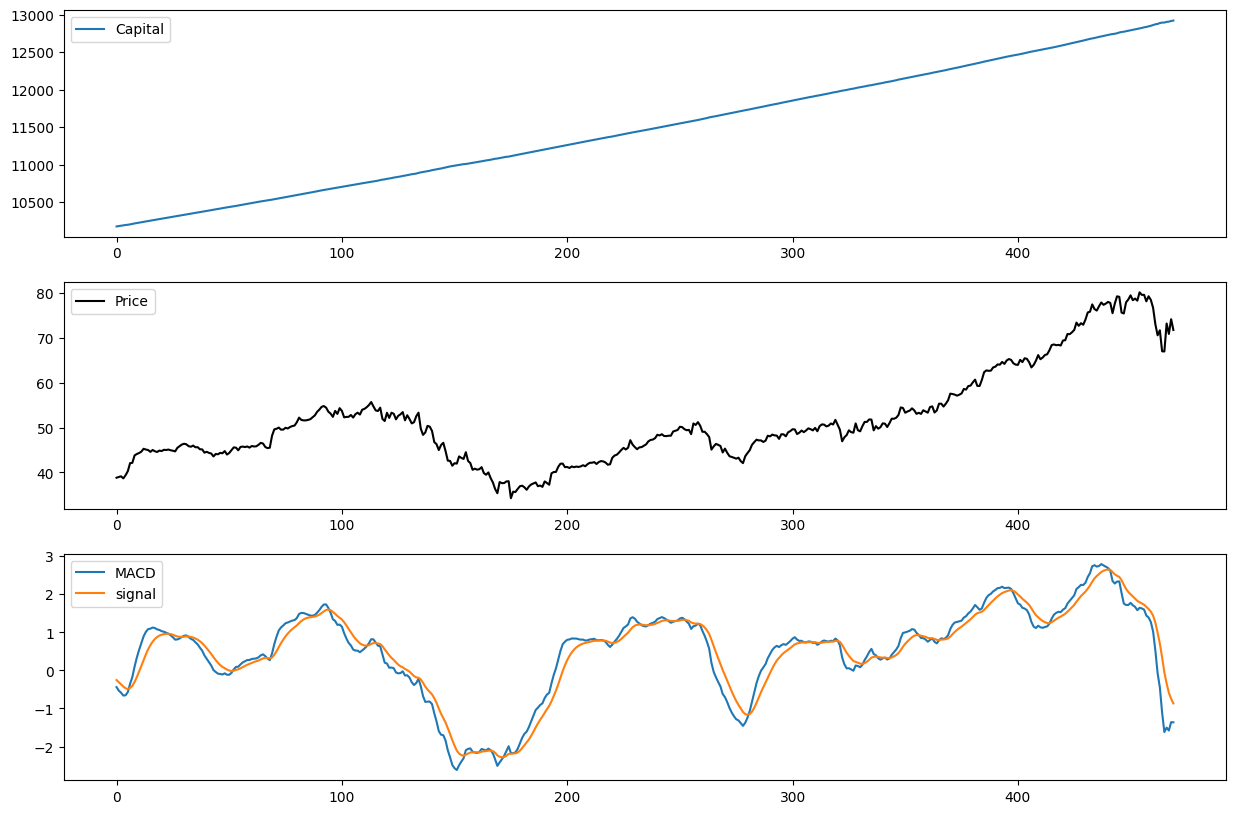

In [7]:
# Plot do gráfico
fig, ax = plt.subplots(3, 1, figsize=(15,10));

ax[0].plot([day[0] for day in modelMACD._days.values()][-len(modelMACD.indicator):])
ax[0].legend(['Capital']);
ax[1].plot(modelMACD.prices[-len(modelMACD.indicator):], color='black');
ax[1].legend(['Price']);
ax[2].plot(modelMACD.indicator);
ax[2].legend(['MACD', 'signal']);

E como seria o equivalente sem o pandas-ta?

Gross Profit: $59.90
Gross Loss: $-36.16
Gross Total: $23.73

Number of trades: 35
Hitting Ratio: 45.71%
Number of profit trades: 16
Number of loss trades: 19
Average number of events per trade: 13.40

Max win trade: $9.40
Avg win trade: $3.74
Max loss trade: $-4.08
Avg loss trade: $-1.90
Avg all trades: $0.68
Win/Loss ratio: 1.97

Max Profit: $12.22
Max Profit High/Low: $13.75
Max Drawdown: $-4.08
Max Drawdown High/Low: $-5.84

Max Allocation: $77.84
Avg Allocation: $48.95
Max Cash Required (margin): $77.84

Gross Total: $23.73
Total Fees: $7.00
Total Taxes: $10.67
Net Total: $6.07

Gross Return: 38.10%
Average Return: 1.09%
Net Return: 2.95%
Net Return Avg Alocation: 12.39%

Number of days: 504
Initial Capital: $100.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $14.45
Net Total + Carry: $20.52
Net Return Capital: 20.52%
Net Return Capital Yearly: 9.78%




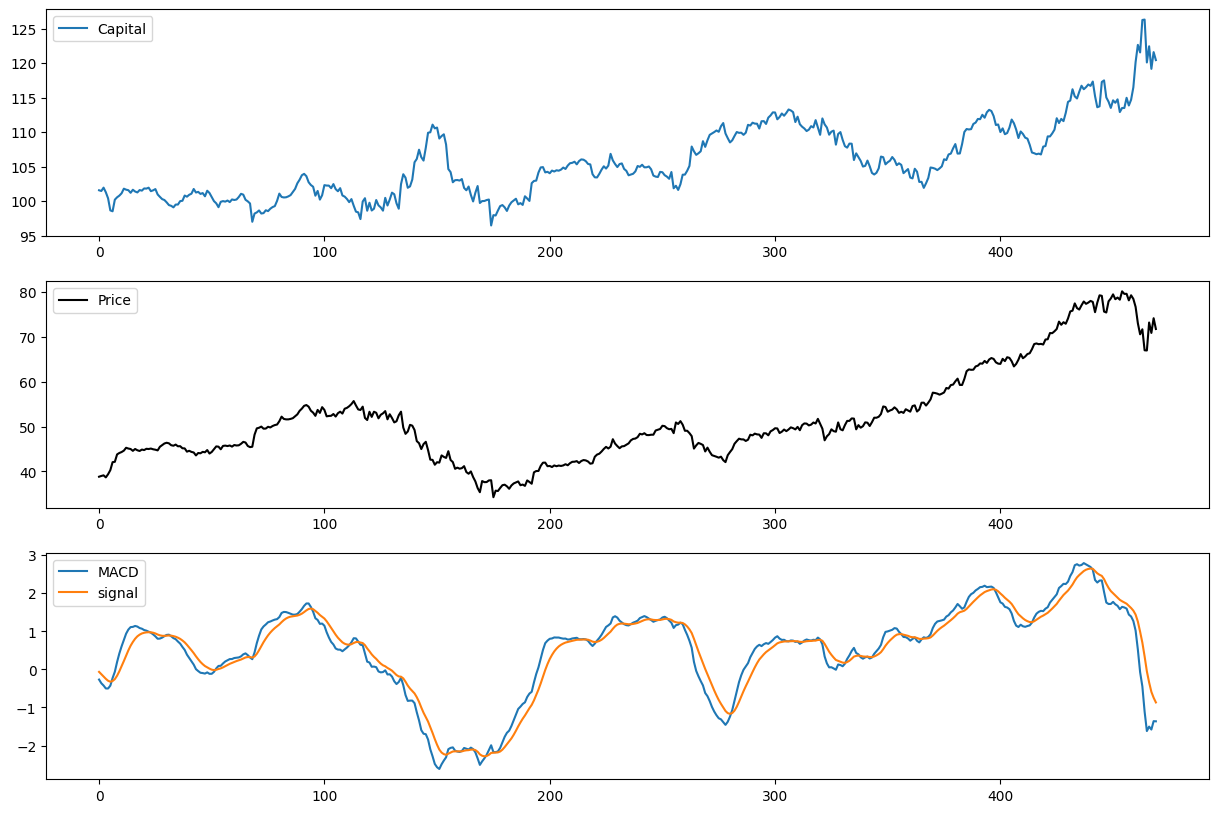

In [8]:
class MACD(Strategy):

    def __init__(self):
        
        # Quantidade de dias de cada média móvel
        self.slow = 26
        self.fast = 12
        self.signal = 9
        
        # Lista para guardar os preços e o indicador
        self.prices = []
        self.indicator = []
    
        # Side da estratégia (+1 Compra/-1 Vende)
        self.side = 0
        
        self.init_capital = 100
        self.avail_capital = self.init_capital


    def receive(self, event):
        
        price = event.price[3] # Captura o preço atual vindo do evento
        
        # Montando a série de preços:
        self.prices.append(price)
        
        # Se a quantidade de preços observados for superior a janela mais lenta + janela de signal
        if len(self.prices) >= self.slow + self.signal:
            
            # Calcular as duas médias exponenciais
            fastEMA = pd.Series(self.prices).ewm(span=self.fast).mean()
            slowEMA = pd.Series(self.prices).ewm(span=self.slow).mean()
            
            # Diferença entre elas
            macd = fastEMA - slowEMA
            
            # Média Móvel Exponencial do MACD
            signalEMA = macd.ewm(span=self.signal).mean()
            
            # Guarda o indicador para o gráfico
            self.indicator.append([macd.iloc[-1], signalEMA.iloc[-1]])
                        
            # O sinal vai ser um valor 1 ou -1
            signal = (macd.iloc[-1] > signalEMA.iloc[-1])*2 - 1
            
            # Ajustando a posição
            if self.side != signal:
                
                if self.side == 1:
                    self.submit(self.id, Order(event.instrument, Order.S, self.side, 0))
                elif self.side == -1:
                    self.submit(self.id, Order(event.instrument, Order.B, -self.side, 0))
                
                if signal == 1:
                    self.submit(self.id, Order(event.instrument, Order.B, signal, 0))
                else:
                    self.submit(self.id, Order(event.instrument, Order.SS, -signal, 0))
                    
                self.side = signal

modelMACD = MACD()
print(evaluateHist(modelMACD, {'AAPL': 'AAPL.csv'}))

# Plot do gráfico
fig, ax = plt.subplots(3, 1, figsize=(15,10));

ax[0].plot([day[0] for day in modelMACD._days.values()][-len(modelMACD.indicator):])
ax[0].legend(['Capital']);
ax[1].plot(modelMACD.prices[-len(modelMACD.indicator):], color='black');
ax[1].legend(['Price']);
ax[2].plot(modelMACD.indicator);
ax[2].legend(['MACD', 'signal']);

Até parece fácil para o MACD, mas, dependendo do indicador, pode ficar bem complicado.

___

### Relative Strengh Index (RSI)

É um oscilador que indica se o mercado está overbought ou oversold. RSI é um indicador que varia de 0 a 100 e estabelece uma banda inferior e uma banda superior. Compra-se quando cruza a banda inferior e vende-se quando cruza a banda superior.

$$ RSI = 100 - 100 ( 1 + up / down) $$

Onde $up$ é a média de retornos positivos do período e $down$ a média de retornos negativos do período.

Pode-se usar média móvel exponencial.

Outras alternativas incluem zerar a posição quando o RSI = 50.

In [9]:
help(ta.rsi)

Help on function rsi in module pandas_ta.momentum.rsi:

rsi(close, length=None, scalar=None, talib=None, drift=None, offset=None, **kwargs)
    Relative Strength Index (RSI)
    
    The Relative Strength Index is popular momentum oscillator used to measure the
    velocity as well as the magnitude of directional price movements.
    
    Sources:
        https://www.tradingview.com/wiki/Relative_Strength_Index_(RSI)
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        ABS = Absolute Value
        RMA = Rolling Moving Average
    
        diff = close.diff(drift)
        positive = diff if diff > 0 else 0
        negative = diff if diff < 0 else 0
    
        pos_avg = RMA(positive, length)
        neg_avg = ABS(RMA(negative, length))
    
        RSI = scalar * pos_avg / (pos_avg + neg_avg)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 14
        scalar (float): How much to magnify.

In [12]:
class RSI(Strategy):

    def __init__(self):
        
        # Quantidade de dias (período)
        self.period = 14
        
        # Bandas
        self.lband = 30 # testar 20 e 30
        self.uband = 70 # testar 80 e 70
        
        # Lista para guardar os preços e o indicador
        self.prices = []
        self.indicator = []
    
        # Side da estratégia (+1 Compra/-1 Vende)
        self.side = 0
        
        self.init_capital = 100
        self.avail_capital = self.init_capital


    def receive(self, event):
        
        price = event.price[3] # Captura o preço atual vindo do evento
        
        # Montando a série de preços:
        self.prices.append(price)
        
        # Se a quantidade de preços observados for superior a janela
        if len(self.prices) >= self.period + 1:
            
            # Monta a lista de preços em um dataframe
            close = pd.DataFrame({'close': self.prices})
            
            # Calcula o RSI com o período indicado
            rsi = close.ta.rsi(lenght = self.period)
                        
            # Guarda o indicador para o gráfico
            self.indicator.append([self.uband, rsi.iloc[-1], self.lband])
                                    
            # Se o RSI estiver abaixo da lower band compra, se estiver acima da upper band vende
            if rsi.iloc[-1] < self.lband:
                signal = 1 
            elif rsi.iloc[-1] > self.uband:
                signal = -1
            else:
                signal = self.side
            
            # Ajustando a posição
            if self.side != signal:
                
                if self.side == 1:
                    self.submit(self.id, Order(event.instrument, Order.S, self.side, 0))
                elif self.side == -1:
                    self.submit(self.id, Order(event.instrument, Order.B, -self.side, 0))
                
                if signal == 1:
                    self.submit(self.id, Order(event.instrument, Order.B, signal, 0))
                else:
                    self.submit(self.id, Order(event.instrument, Order.SS, -signal, 0))
                    
                self.side = signal

modelRSI = RSI()
print(evaluateHist(modelRSI, {'AAPL': 'AAPL.csv'}))

Gross Profit: $25.66
Gross Loss: $-8.41
Gross Total: $17.25

Number of trades: 6
Hitting Ratio: 83.33%
Number of profit trades: 5
Number of loss trades: 1
Average number of events per trade: 76.33

Max win trade: $16.12
Avg win trade: $5.13
Max loss trade: $-8.41
Avg loss trade: $-8.41
Avg all trades: $2.88
Win/Loss ratio: 0.61

Max Profit: $16.12
Max Profit High/Low: $17.72
Max Drawdown: $-21.57
Max Drawdown High/Low: $-23.32

Max Allocation: $67.05
Avg Allocation: $49.91
Max Cash Required (margin): $67.05

Gross Total: $17.25
Total Fees: $1.20
Total Taxes: $4.14
Net Total: $11.91

Gross Return: 41.56%
Average Return: 6.93%
Net Return: 30.11%
Net Return Avg Alocation: 23.85%

Number of days: 504
Initial Capital: $100.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $18.25
Net Total + Carry: $30.16
Net Return Capital: 30.16%
Net Return Capital Yearly: 14.09%




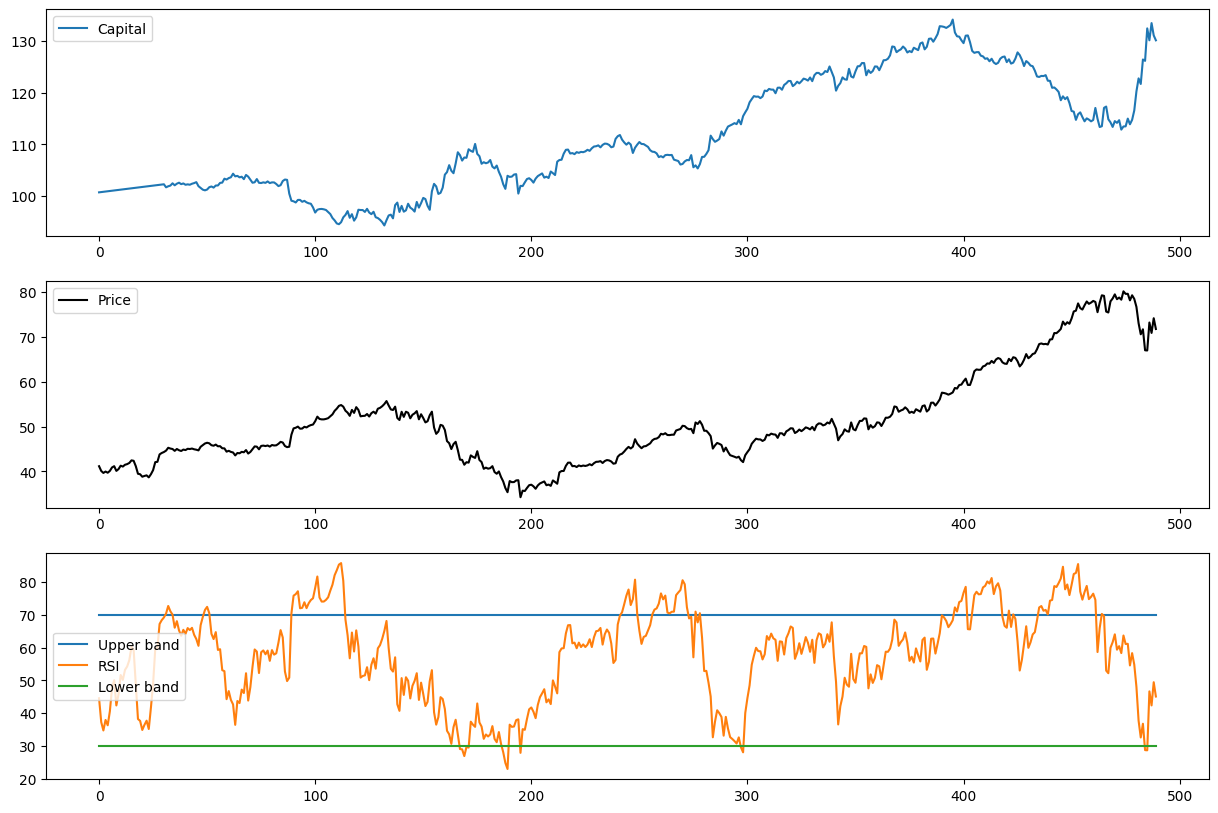

In [13]:
# Plot do gráfico
fig, ax = plt.subplots(3, 1, figsize=(15,10));

ax[0].plot([day[0] for day in modelRSI._days.values()][-len(modelRSI.indicator):])
ax[0].legend(['Capital']);
ax[1].plot(modelRSI.prices[-len(modelRSI.indicator):], color='black');
ax[1].legend(['Price']);
ax[2].plot(modelRSI.indicator);
ax[2].legend(['Upper band', 'RSI', 'Lower band']);

### Bollinger Bands

É um indicador bem simples. Calcula-se um envelope em torno da média móvel, representado por uma quantidade de desvios padrão da média de um período n.

$$ Upper band = avg(p, n) + m * std(p, n)$$
$$ Lower band = avg(p, n) - m * std(p, n)$$

Para extrair o sinal pode-se considerar várias situações:

1. Quando o preço tocar a banda inferior compra. E na banda superior vende.
2. Pode zerar a posição quando o preço cruzar a média móvel.
3. Pode-se utilizar um m baixo e um n rápido e atuar como trend follower.
4. etc

In [ ]:
help(ta.bbands)

In [14]:
class Bollinger(Strategy):

    def __init__(self):
        
        # Quantidade de dias de cada média móvel
        self.period = 14
        
        # Número de desvios da banda
        self.m = 1 # testar 1.5
        
        # Lista para guardar os preços e o indicador
        self.prices = []
        self.indicator = []
    
        # Side da estratégia (+1 Compra/-1 Vende)
        self.side = 0
        
        self.init_capital = 100
        self.avail_capital = self.init_capital


    def receive(self, event):
        
        price = event.price[3] # Captura o preço atual vindo do evento
        
        # Montando a série de preços:
        self.prices.append(price)
        
        # Se a quantidade de preços observados for superior a janela
        if len(self.prices) >= self.period + 1:
            
            # Monta a lista de preços em um dataframe
            close = pd.DataFrame({'close': self.prices})
            
            bbands = close.ta.bbands(lenght = self.period, std = self.m)            
            
            down = bbands.iloc[-1, 0]
            avg = bbands.iloc[-1, 1]
            up = bbands.iloc[-1, 2]
            
            # Guarda os dados para o gráfico
            self.indicator.append([up, avg, down])
                                    
            # Se o preço estiver abaixo da banda inferior compra, senão vende
            if price < down:
                signal = -1 
            elif price > up:
                signal = 1
            elif price > avg and self.side == -1:
                signal = 0
            elif price < avg and self.side == 1:
                signal = 0
            else:
                signal = self.side
            
            # Ajustando a posição
            if self.side != signal:
                
                if self.side == 1:
                    self.submit(self.id, Order(event.instrument, Order.S, self.side, 0))
                elif self.side == -1:
                    self.submit(self.id, Order(event.instrument, Order.B, -self.side, 0))
                
                if signal == 1:
                    self.submit(self.id, Order(event.instrument, Order.B, signal, 0))
                else:
                    self.submit(self.id, Order(event.instrument, Order.SS, -signal, 0))
                    
                self.side = signal

modelBollinger = Bollinger()
print(evaluateHist(modelBollinger, {'AAPL': 'AAPL.csv'}))

Gross Profit: $57.06
Gross Loss: $-71.08
Gross Total: $-14.02

Number of trades: 98
Hitting Ratio: 33.67%
Number of profit trades: 33
Number of loss trades: 65
Average number of events per trade: 4.15

Max win trade: $6.69
Avg win trade: $1.73
Max loss trade: $-3.79
Avg loss trade: $-1.09
Avg all trades: $-0.14
Win/Loss ratio: 1.58

Max Profit: $11.19
Max Profit High/Low: $14.10
Max Drawdown: $-3.79
Max Drawdown High/Low: $-4.75

Max Allocation: $80.21
Avg Allocation: $50.65
Max Cash Required (margin): $80.21

Gross Total: $-14.02
Total Fees: $19.60
Total Taxes: $13.47
Net Total: $-47.09

Gross Return: -26.51%
Average Return: -0.27%
Net Return: -93.17%
Net Return Avg Alocation: -92.96%

Number of days: 504
Initial Capital: $100.00
Risk Free Rate: 13.75% yearly/0.0511% daily
Total Carry: $11.67
Net Total + Carry: $-35.42
Net Return Capital: -35.42%
Net Return Capital Yearly: -19.64%




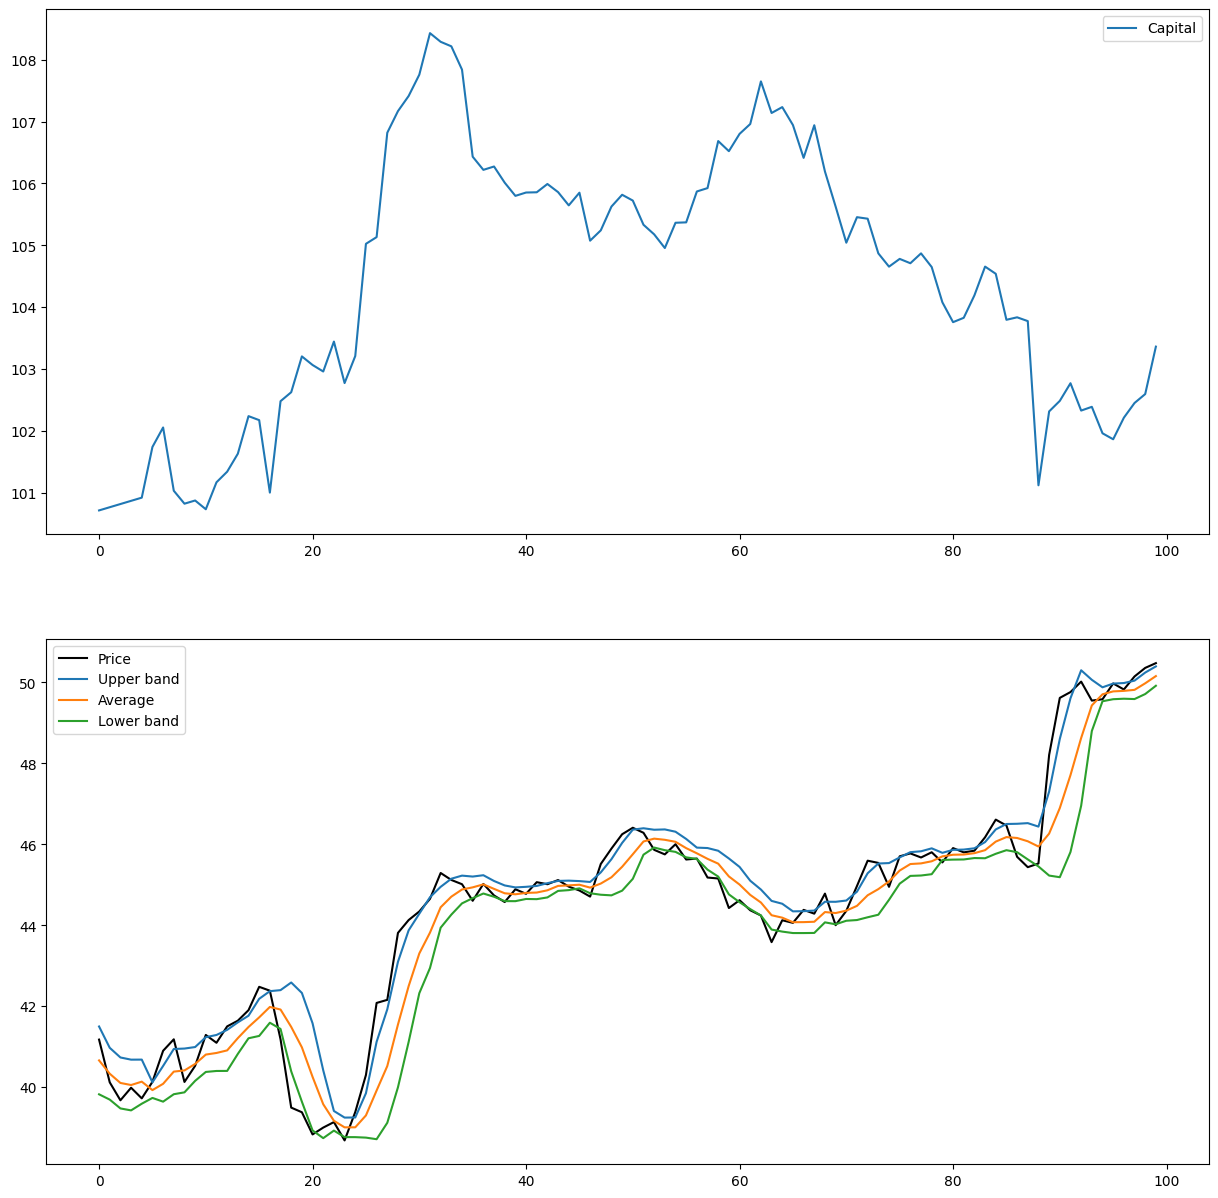

In [15]:
# Plot do gráfico
fig, ax = plt.subplots(2, 1, figsize=(15,15));

shift = -len(modelBollinger.indicator)
ax[0].plot([day[0] for day in modelBollinger._days.values()][shift:100+shift])
ax[0].legend(['Capital']);
ax[1].plot(modelBollinger.prices[shift:100+shift], color='black');
ax[1].plot(modelBollinger.indicator[:100]);
ax[1].legend(['Price', 'Upper band', 'Average', 'Lower band']);